## Load config file for paths, etc

In [3]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import configparser
import os
import json
import cv2
import matplotlib.pyplot as plt
from skimage import data, io, filters
from tqdm import tqdm
from src.fct import interpolation_ppg
import torchvision
from torchvision.transforms import RandomRotation, ToPILImage, ToTensor, ColorJitter
import random
import math

In [5]:
configFilename = 'config/PURE_PhysNet_v7_JS.cfg'
parser = configparser.ConfigParser(inline_comment_prefixes=('#', ';'))
parser.optionxform = str
parser.read(configFilename)
cfgdict = dict(parser['DEFAULT'].items())
cfgdict

{'dataset': 'PURE',
 'model': 'PhysNet',
 'videodataDIR_test': 'D:/work/rPPG/Dataset/PURE/09-01/09-01,D:/work/rPPG/Dataset/PURE/10-01/10-01',
 'signalpath_test': 'D:/work/rPPG/Dataset/PURE/09-01/09-01.json,D:/work/rPPG/Dataset/PURE/10-01/10-01.json',
 'videodataDIR_train': 'D:/work/rPPG/Dataset/PURE/01-01/01-01,D:/work/rPPG/Dataset/PURE/02-01/02-01,D:/work/rPPG/Dataset/PURE/03-01/03-01,D:/work/rPPG/Dataset/PURE/04-01/04-01,D:/work/rPPG/Dataset/PURE/05-01/05-01',
 'signalpath_train': 'D:/work/rPPG/Dataset/PURE/01-01/01-01.json,D:/work/rPPG/Dataset/PURE/02-01/02-01.json,D:/work/rPPG/Dataset/PURE/03-01/03-01.json,D:/work/rPPG/Dataset/PURE/04-01/04-01.json,D:/work/rPPG/Dataset/PURE/05-01/05-01.json',
 'batch_size': '8',
 'learning_rate': '1e-3',
 'depth': '32',
 'height': '128',
 'width': '128',
 'crop': 'True'}

In [6]:
vdir, sigdir = cfgdict['videodataDIR_test'].split(','), cfgdict['signalpath_test'].split(',')
vdir, sigdir

(['D:/work/rPPG/Dataset/PURE/09-01/09-01',
  'D:/work/rPPG/Dataset/PURE/10-01/10-01'],
 ['D:/work/rPPG/Dataset/PURE/09-01/09-01.json',
  'D:/work/rPPG/Dataset/PURE/10-01/10-01.json'])

# DatasetPhysNetED 수정

In [9]:
class DatasetPhysNetEDHDF5(Dataset):
    """
        Dataset class for PhysNet neural network.
    """
    def __init__(self, cfgdict, isTrain = True):
        if isTrain == True:
            overlap = 0.75; hflip=True; rand_shift = True
            video_dir_str = 'videodataDIR_train'
            signal_path_str = 'signalpath_train'
            
        else:
            overlap = 0; hflip=False; rand_shift = False
            video_dir_str = 'videodataDIR_test'
            signal_path_str = 'signalpath_test'
        
        ppg_offset = 6
        self.hflip = hflip
        self.random_shift = rand_shift
        self.ppgs = []
        self.vfls = []
        self.face_rects = []
        self.nums = []
        self.num_samples = 0
        
        self.vdirs = cfgdict[video_dir_str].split(',')
        self.sigdirs = cfgdict[signal_path_str].split(',')
        for vdir, sigdir in zip(self.vdirs, self.sigdirs):
            # Load video image list
            vfl = sorted(os.listdir(vdir))
            start = 0
            end = len(vfl)
            vfl_origin = vfl
            vfl = vfl[start:end-ppg_offset]
            self.vfls.append(vfl)
            
            # Load PPG signals
            with open(sigdir, "r") as st_json:
                data_json = json.load(st_json)
            time_ns = list()
            ppg = list()
            for dat in data_json['/FullPackage']:
                time_ns.append(dat['Timestamp'])
                ppg.append(dat['Value']['waveform'])
            time_ns = np.array(time_ns)
            ppg = np.array(ppg)
            imgt = list()
            
            for fn in vfl_origin:
                imgt.append(int(os.path.splitext(fn)[0][5:]))
            imgt = np.array(imgt)        
            imgt2 = (imgt - imgt[0])/1e6
            time_ns2 = (time_ns - imgt[0])/1e6
            ppg = interpolation_ppg(imgt2, time_ns2, ppg, normalize = True)
            ppg = np.array(ppg)[start + ppg_offset:end]
            self.ppgs.append(ppg)

            # Image config
            self.depth = int(cfgdict['depth'])
            self.height = int(cfgdict['height'])
            self.width = int(cfgdict['width'])
            self.channel = 3
            self.overlap = overlap
            self.shift = int(self.depth*(1-self.overlap))  # overlap, s.t., 0=< overlap < 1
            num_samples = math.ceil((end - start - self.depth)/self.shift)+1

            self.num_samples += num_samples
            if len(self.nums)==0:
                self.nums.append(self.num_samples-1)
            else:
                self.nums.append(self.num_samples-1)

            self.crop = bool(cfgdict['crop'])
            #         if crop:        
            # Crop Face Rectangle - from 1st image
            vfpath = os.path.join(vdir,vfl[0])
            img = io.imread(vfpath)

            dpath = "config/haarcascade_frontalface_alt.xml"
            if not os.path.exists(dpath):
                print("Cascade file not present!")
            face_cascade = cv2.CascadeClassifier(dpath)

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            detected = list(face_cascade.detectMultiScale(gray, 1.1, 4))

            if len(detected) > 0:
                detected.sort(key=lambda a: a[-1] * a[-2])
                face_rect = detected[-1]
            self.face_rects.append(face_rect)

    def __len__(self):
        return self.num_samples 
    
    def __getitem__(self, idx):
        # -------------------------------
        # Fill video with frames
        # -------------------------------
        # conv3d input: N x C x D x H X W
        sample_num = 0
        while idx>self.nums[sample_num]:
            sample_num += 1
        if idx > self.nums[sample_num-1]:
            idx = idx - self.nums[sample_num-1] - 1        
            
        x, y, w, h = self.face_rects[sample_num]
        shift = self.shift
        depth = self.depth
        height = self.height
        width = self.width
        channel = self.channel
        video = torch.empty(channel, depth, height, width, dtype=torch.float)      
        if self.random_shift:
            rand_offset = int(depth*(1-overlap)*0.5)
            rand_shift = random.randint(-rand_offset, rand_offset)
        else:
            rand_shift = 0

        start_frame = idx * shift + rand_shift
        end_frame = idx * shift + depth + rand_shift
        # range 넘어가면 rand_shift 안 시킴.
        start = 0
        end = len(self.vfls[sample_num])
        while start+start_frame < start:
            start_frame += 1
            end_frame += 1
        while start + end_frame >= end or start + end_frame >= len(self.ppgs[sample_num]) + start:
            
            start_frame -= 1
            end_frame -= 1

        for cnt, fn in enumerate(self.vfls[sample_num][start_frame : end_frame]):
            vfpath = os.path.join(self.vdirs[sample_num],fn)
            img = io.imread(vfpath)
            if self.crop:        
                img = img[y:y + h, x: x + w, :]
            img = cv2.resize(img, (height, width), interpolation=cv2.INTER_CUBIC)
            img = ToTensor()(img)
            img = torch.sub(img, torch.mean(img, (1, 2)).view(3, 1, 1))  # spatial intensity norm for each channel

            # TODO: add jitter and flip
            if self.hflip:
                rand_flip = bool(random.getrandbits(1))
                if rand_flip:
                    img = torchvision.transforms.functional.hflip(img)

            video[:, cnt, :, :] = img  # video -> C, D, H, W
            
        target = self.ppgs[sample_num][start_frame :  end_frame]
        target = torch.tensor(target, dtype=torch.float)
        return video, target

In [10]:
overlap = 0.75
batch_size = 32
trainset = DatasetPhysNetEDHDF5(cfgdict, isTrain = True)
testset = DatasetPhysNetEDHDF5(cfgdict, isTrain = False)

# Construct DataLoaders
trainloader = DataLoader(trainset,
                         batch_size = batch_size)
testloader = DataLoader(testset,
                         batch_size = batch_size)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [11]:
video, target = trainset.__getitem__(1)
video.shape, target.shape

(torch.Size([3, 32, 128, 128]), torch.Size([32]))

In [13]:
from src.archs import PhysNetED

import torch
import torch.nn as nn
import gc
gc.collect()
torch.cuda.empty_cache()

model = PhysNetED()
if device != 'cpu':
    model = model.cuda()
loss_fn = nn.MSELoss()
learning_rate = float(cfgdict['learning_rate'])
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [16]:
model.train(False)
model.load_state_dict(torch.load('checkpoints/PhysNet_v7_9_10_model_ep99.pth',map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
iter_loader = iter(testloader)
videos, targets = next(iter_loader)

In [18]:
pred_ppg = model(videos)

In [19]:
pred_ppg[0].squeeze().detach().numpy(), targets[0].shape

(array([ 2.1182215 ,  1.6304348 ,  1.2738801 ,  0.98648876,  0.92309093,
         0.9123285 ,  0.81636703,  0.7141389 ,  0.51951593,  0.40925765,
         0.28306112,  0.26838526,  0.19725084,  0.09404321,  0.06053597,
        -0.00279773, -0.03278885, -0.15888491, -0.24890162, -0.30454284,
        -0.28525797, -0.41280404, -0.49403   , -0.60011643, -0.63425523,
        -0.66399163, -0.71198434, -0.821646  , -0.86419624, -0.7527542 ,
        -0.57628715, -0.16768177], dtype=float32),
 torch.Size([32]))

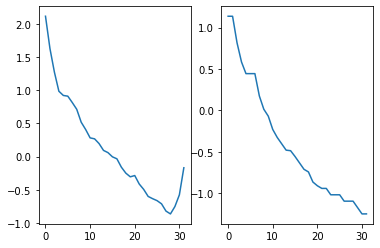

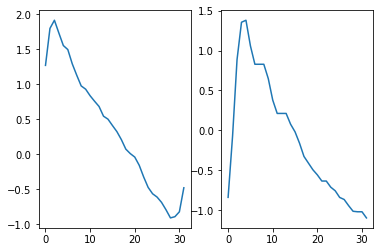

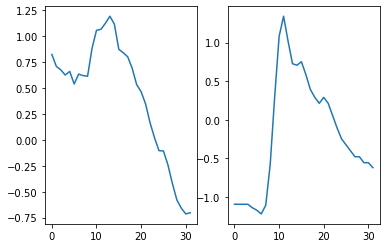

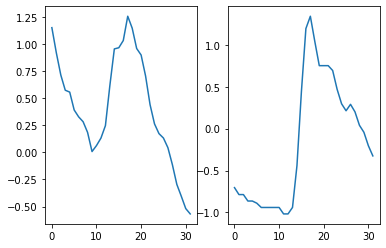

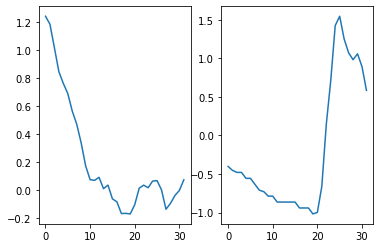

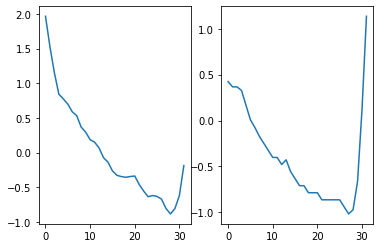

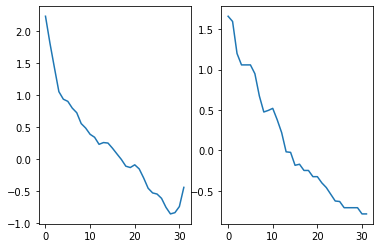

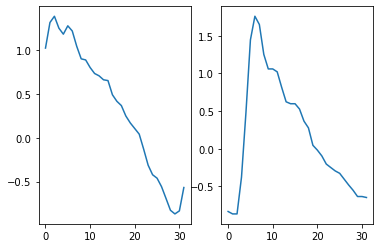

In [20]:
for i in range(8):
    plt.subplot(121)
    plt.plot(pred_ppg[i].squeeze().detach().numpy())
    plt.subplot(122)
    plt.plot(targets[i])
    plt.show()
